In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

> https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [2]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [3]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Mounted at /content/gdrive/


In [4]:
##### remove blood_cell in blood_cell
source_dir = '/content/blood_cell/blood_cell'
target_dir = '/content/blood_cell'

# Get a list of directories in the source directory
directories = next(os.walk(source_dir))[1]

# Move each directory to the target directory
for directory in directories:
    source_path = os.path.join(source_dir, directory)
    target_path = os.path.join(target_dir, directory)
    shutil.move(source_path, target_path)

directory_to_remove = '/content/blood_cell/blood_cell'

# Remove the directory and its contents
shutil.rmtree(directory_to_remove)

In [5]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))


test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2499
test label : MONOCYTE  =>  2478
test label : EOSINOPHIL  =>  2497
test label : LYMPHOCYTE  =>  2483
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  624
test label : MONOCYTE  =>  620
test label : EOSINOPHIL  =>  623
test label : LYMPHOCYTE  =>  620
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
val label : NEUTROPHIL  =>  48
val label : MONOCYTE  =>  4
val label : EOSINOPHIL  =>  13
val label : LYMPHOCYTE  =>  6


In [6]:
##### Let's shuffle

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']


In [7]:
##### Move to TRAIN at all files in TEST
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

624 is moved into NEUTROPHIL(TEST => Train)
620 is moved into MONOCYTE(TEST => Train)
623 is moved into EOSINOPHIL(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)


In [8]:
##### Move to TRAIN all files in TEST_SIMPLE
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)
4 is moved into MONOCYTE(TEST_SIMPLE => Train)
13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)


In [9]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  3171
test label : MONOCYTE  =>  3095
test label : EOSINOPHIL  =>  3133
test label : LYMPHOCYTE  =>  3108


In [10]:

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1

    print("total move num => ", move_num)
    print("=============================================")

total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634
total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621


In [11]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2537
test label : MONOCYTE  =>  2476
test label : EOSINOPHIL  =>  2507
test label : LYMPHOCYTE  =>  2487
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  634
test label : MONOCYTE  =>  619
test label : EOSINOPHIL  =>  626
test label : LYMPHOCYTE  =>  621


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 224, 224, 3) (16,)
[0. 0. 1. 2. 1. 2. 3. 2. 2. 1. 0. 2. 3. 2. 2. 3.]
94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
               

251/251 [==============================] - 100s 211ms/step - loss: 1.5403 - acc: 0.2558 - val_loss: 1.5942 - val_acc: 0.2485
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 1.3181 - acc: 0.3546
Epoch 2: val_loss improved from 1.59422 to 1.52449, saving model to content/


251/251 [==============================] - 49s 195ms/step - loss: 1.3181 - acc: 0.3546 - val_loss: 1.5245 - val_acc: 0.2620
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 1.0607 - acc: 0.5155
Epoch 3: val_loss improved from 1.52449 to 1.38909, saving model to content/


251/251 [==============================] - 50s 197ms/step - loss: 1.0607 - acc: 0.5155 - val_loss: 1.3891 - val_acc: 0.2690
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 0.7570 - acc: 0.6921
Epoch 4: val_loss improved from 1.38909 to 0.80762, saving model to content/


251/251 [==============================] - 49s 194ms/step - loss: 0.7570 - acc: 0.6921 - val_loss: 0.8076 - val_acc: 0.7590
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 0.5641 - acc: 0.7858
Epoch 5: val_loss improved from 0.80762 to 0.20841, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.5641 - acc: 0.7858 - val_loss: 0.2084 - val_acc: 0.9415
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 0.4487 - acc: 0.8345
Epoch 6: val_loss improved from 0.20841 to 0.14343, saving model to content/


251/251 [==============================] - 49s 197ms/step - loss: 0.4487 - acc: 0.8345 - val_loss: 0.1434 - val_acc: 0.9525
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 0.3425 - acc: 0.8739
Epoch 7: val_loss improved from 0.14343 to 0.11224, saving model to content/


251/251 [==============================] - 50s 198ms/step - loss: 0.3425 - acc: 0.8739 - val_loss: 0.1122 - val_acc: 0.9565
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 0.2561 - acc: 0.9122
Epoch 8: val_loss improved from 0.11224 to 0.09046, saving model to content/


251/251 [==============================] - 49s 196ms/step - loss: 0.2561 - acc: 0.9122 - val_loss: 0.0905 - val_acc: 0.9675
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 0.1983 - acc: 0.9292
Epoch 9: val_loss improved from 0.09046 to 0.06482, saving model to content/


251/251 [==============================] - 49s 196ms/step - loss: 0.1983 - acc: 0.9292 - val_loss: 0.0648 - val_acc: 0.9805
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 0.1724 - acc: 0.9423
Epoch 10: val_loss improved from 0.06482 to 0.06199, saving model to content/


251/251 [==============================] - 49s 196ms/step - loss: 0.1724 - acc: 0.9423 - val_loss: 0.0620 - val_acc: 0.9840
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.1498 - acc: 0.9482
Epoch 11: val_loss did not improve from 0.06199
251/251 [==============================] - 21s 82ms/step - loss: 0.1498 - acc: 0.9482 - val_loss: 0.0644 - val_acc: 0.9800
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.1205 - acc: 0.9608
Epoch 12: val_loss did not improve from 0.06199
251/251 [==============================] - 21s 83ms/step - loss: 0.1205 - acc: 0.9608 - val_loss: 0.0786 - val_acc: 0.9825
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.1074 - acc: 0.9657
Epoch 13: val_loss improved from 0.06199 to 0.05700, saving model to content/


251/251 [==============================] - 49s 196ms/step - loss: 0.1074 - acc: 0.9657 - val_loss: 0.0570 - val_acc: 0.9860
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.9684
Epoch 14: val_loss did not improve from 0.05700
251/251 [==============================] - 21s 82ms/step - loss: 0.0924 - acc: 0.9684 - val_loss: 0.1306 - val_acc: 0.9720
Epoch 15/20
251/251 [==============================] - ETA: 0s - loss: 0.0880 - acc: 0.9710
Epoch 15: val_loss did not improve from 0.05700
251/251 [==============================] - 21s 82ms/step - loss: 0.0880 - acc: 0.9710 - val_loss: 0.0736 - val_acc: 0.9860
Epoch 16/20
251/251 [==============================] - ETA: 0s - loss: 0.0698 - acc: 0.9779
Epoch 16: val_loss did not improve from 0.05700
251/251 [==============================] - 20s 81ms/step - loss: 0.0698 - acc: 0.9779 - val_loss: 0.0681 - val_acc: 0.9870
Epoch 17/20
251/251 [==============================] - ETA: 0s - loss: 0.0662 - acc: 0.

251/251 [==============================] - 49s 196ms/step - loss: 0.0597 - acc: 0.9803 - val_loss: 0.0568 - val_acc: 0.9875
Epoch 19/20
251/251 [==============================] - ETA: 0s - loss: 0.0493 - acc: 0.9820
Epoch 19: val_loss did not improve from 0.05680
251/251 [==============================] - 21s 82ms/step - loss: 0.0493 - acc: 0.9820 - val_loss: 0.0768 - val_acc: 0.9855
Epoch 20/20
251/251 [==============================] - ETA: 0s - loss: 0.0583 - acc: 0.9843
Epoch 20: val_loss did not improve from 0.05680
251/251 [==============================] - 21s 82ms/step - loss: 0.0583 - acc: 0.9843 - val_loss: 0.0746 - val_acc: 0.9835
Elapsed Time :  0:13:27.323578


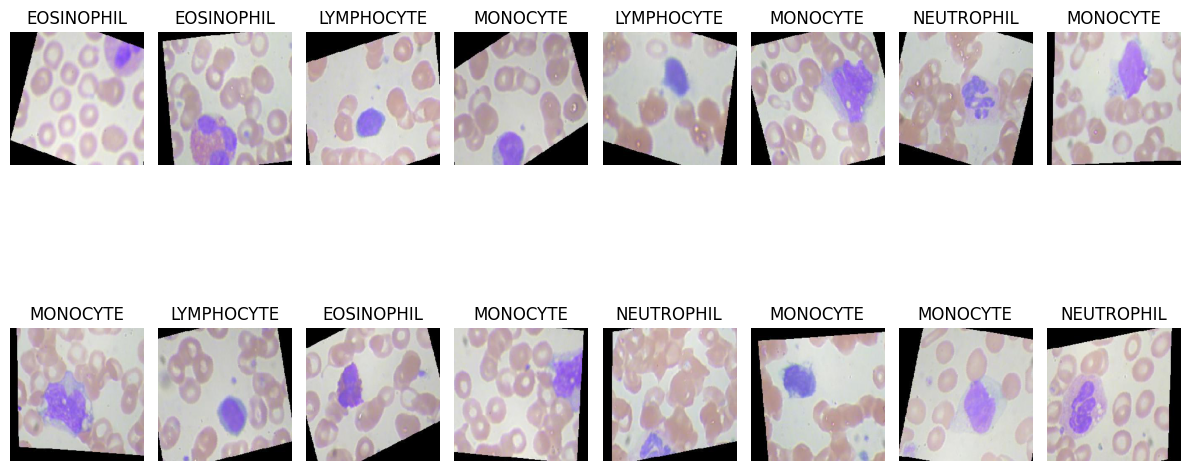

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

pre_trained_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-5), metrics=["acc"])

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

result = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

63/63 [==============================] - 4s 65ms/step - loss: 0.0746 - acc: 0.9835


[0.07463360577821732, 0.9835000038146973]

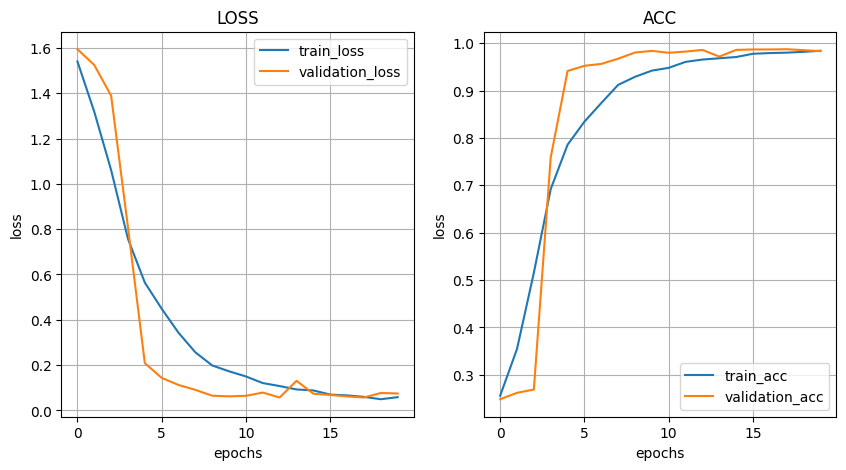

In [13]:
# include_top = False
# ResNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")

model.evaluate(val_generator)